In [2]:
import pandas as pd
import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [3]:
# ── Global visualisation configuration ──────────────────────────────────────

# 1.  General Matplotlib defaults
# ── Global visualisation configuration ──────────────────────────────────────
import matplotlib as mpl
import seaborn as sns

mpl.rcParams.update({
    # ── Canvas size & resolution ───────────────────────────────────────────
    # Default figure size: 12×8 inches  →  4800×3200 px when exported at 400 dpi
    "figure.figsize": (12, 8),
    "figure.dpi": 200,       # crisp in-notebook / retina preview
    "savefig.dpi": 400,      # print-quality PNG/PDF

    # ── Fonts ──────────────────────────────────────────────────────────────
    "font.family": "sans-serif",
    "font.sans-serif": ["Roboto", "DejaVu Sans", "Arial"],
    "axes.titlesize": 24,
    # "axes.titleweight": "bold",
    "axes.labelsize": 24,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 20,

    # ── Axis & spine aesthetics ────────────────────────────────────────────
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.linewidth": 1,
    "axes.grid": True,
    "grid.color": "#E6E6E6",
    "grid.linewidth": 0.4,
    "grid.alpha": 0.8,

    # ── Colour cycle (colour-blind-safe) ───────────────────────────────────
    "axes.prop_cycle": mpl.cycler(color=sns.color_palette("Set2")),

    # ── Figure background ─────────────────────────────────────────────────
    "figure.facecolor": "white",
})

# Seaborn theme inherits the rcParams above
sns.set_theme(context="talk", style="whitegrid", palette="Set2")


# 2.  Seaborn theme (inherits Matplotlib rcParams)
sns.set_theme(
    context="talk",           # slightly larger fonts for presentations / papers
    style="whitegrid",        # grid only on y-axis (good for histograms)
    palette="Set2",           # matches the rcParams colour cycle
)

# 3.  Helper function for consistent figure export
def savefig_nice(fig, filename, *, tight=True, dpi=300, **savefig_kwargs):
    """Save figure with tight layout and correct DPI."""
    if tight:
        fig.tight_layout()
    fig.savefig(filename, dpi=dpi, bbox_inches="tight", transparent = True, **savefig_kwargs)

# 4.  Colour constants for this project (optional convenience)
COL_RAW      = "#1f77b4"  # e.g. unweighted sample
COL_WEIGHTED = "#d62728"  # weighted sample
COL_REF      = "0.35"                        # census reference (neutral grey)


In [4]:
ATLAS = "schaefer2018tian2020_400_7"
region_col = "index"
# Load important files
DATA_DIR = Path("/home/galkepler/Projects/neuroaging/data")

# Output directory for figures
OUTPUT_DIR = Path("/home/galkepler/Projects/neuroaging/figures/fig3")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load the data
parcels = pd.read_csv(DATA_DIR / "external" /"atlases" / ATLAS / "parcels.csv", index_col = 0)
nifti = DATA_DIR / "external" / "atlases" / ATLAS / "atlas.nii.gz"
nifti_matlab = DATA_DIR / "external" / "atlases" / ATLAS / "atlas_matlab.nii"

In [5]:
metrics = ["gm_vol","adc","fa","ad","rd"]
distribution_metric = "qfmean"

bad_subjects = ["IN120120"]

# Load the data
data = {}
for metric in metrics:
    data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)
    # drop problematic subjects
    data[metric] = data[metric][~data[metric]["subject_code"].isin(bad_subjects)]
    data[metric]["sex"] = data[metric]["sex"].map({"M": 0, "F": 1})



# data["age_squared"] = data["age_at_scan"] ** 2

/tmp/ipykernel_123201/2081395043.py:9: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)
/tmp/ipykernel_123201/2081395043.py:9: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)
/tmp/ipykernel_123201/2081395043.py:9: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)
/tmp/ipykernel_123201/2081395043.py:9: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)
/tmp/ipykernel_12

In [6]:
metric_cols = {metric: "volume" if metric == "gm_vol" else distribution_metric for metric in metrics}

for m, df in data.items():
    df = df.rename(columns={metric_cols[m]: "value"})
    data[m] = df


In [7]:
israel_population = pd.read_csv(DATA_DIR / "processed" / "israel_population.csv")

In [8]:
import numpy as np
import pandas as pd


# ─────────────────────────────────────────────────────────────────────────────
def compute_poststrat_weights(
    sample_df: pd.DataFrame,
    pop_df: pd.DataFrame,
    *,
    age_col: str = "age_at_scan",
    start_col: str = "range_start",
    end_col: str = "range_end",
    pop_total_col: str = "total",
    cap: float | None = None,
    return_bin_table: bool = False,
):
    """
    Post-stratification weights so that the age distribution of *sample_df*
    matches an external population distribution supplied in *pop_df*.

    Parameters
    ----------
    sample_df : DataFrame with an ``age_col`` column (years; int or float).
    pop_df    : DataFrame with columns
                    [start_col, end_col, pop_total_col].
                * Values in ``pop_total_col`` can be counts **or** percentages
                  (they are internally re-scaled to proportions).
                * The row order doesn’t matter; they will be sorted.
    cap       : Optional float.  If provided, weights are truncated at
                ``cap × mean(weight)`` and then re-scaled so mean(weight)=1.
    return_bin_table : If True, also return a DataFrame summarising
                       n_sample, n_pop, and weight_factor for every bin.

    Returns
    -------
    weights   : 1-D numpy array aligned with ``sample_df.index``.
    bin_table : (optional) tidy per-bin summary (see above).
    """

    # 1 ── tidy & validate the population table --------------------------------
    pop = (
        pop_df[[start_col, end_col, pop_total_col]]
        .dropna()
        .astype({start_col: int, end_col: int, pop_total_col: float})
        .sort_values(start_col)  # your CSV is descending; fix that
        .reset_index(drop=True)
    )

    if (pop[end_col] <= pop[start_col]).any():
        raise ValueError("Each range_end must exceed range_start.")

    if (pop[start_col].iloc[1:].values < pop[end_col].iloc[:-1].values).any():
        overlap = pop.iloc[
            np.where(pop[start_col].iloc[1:].values < pop[end_col].iloc[:-1].values)[0] + 1
        ][[start_col, end_col]]
        raise ValueError(
            "Age bins overlap (rows shown below) — "
            "merge / correct them before weighting:\n"
            f"{overlap}"
        )

    # 2 ── build right-inclusive bin edges  (···| s_i  …  e_i | s_{i+1} …) ----
    edges = pop[start_col].tolist() + [pop[end_col].iloc[-1]]

    # 3 ── assign every participant to a bin -----------------------------------
    s_bins = pd.cut(
        sample_df[age_col],
        bins=edges,
        right=True,
        include_lowest=True,
        labels=pop.index,  # categorical labels 0,1,…
    )

    # 4 ── compute *sample* and *population* proportions per bin --------------
    n_sample = s_bins.value_counts(sort=False).sort_index()
    prop_sample = n_sample / n_sample.sum()

    prop_pop = pop[pop_total_col] / pop[pop_total_col].sum()

    # 5 ── weight factor = pop_prop / sample_prop ------------------------------
    weight_factor = prop_pop / prop_sample.replace(0, np.nan)  # avoid /0 → NaN

    # 6 ── map factor back to each row ----------------------------------------
    w = s_bins.map(weight_factor).astype(float).to_numpy()
    w = np.where(np.isnan(w), 0.0, w)  # rows that fell outside bins → 0

    # 7 ── optional weight truncation (winsorisation) --------------------------
    if cap is not None and cap > 0:
        mean_pos = w[w > 0].mean()
        w = np.clip(w, 0, cap * mean_pos)

    # 8 ── re-scale so mean(weight > 0) == 1 -----------------------------------
    positive = w > 0
    w[positive] = w[positive] / w[positive].mean()

    # 9 ── return --------------------------------------------------------------
    if return_bin_table:
        bin_tbl = pd.DataFrame(
            {
                "n_sample": n_sample,
                "n_pop": prop_pop * n_sample.sum(),  # rescaled to sample size
                "prop_sample": prop_sample,
                "prop_pop": prop_pop,
                "weight_factor": weight_factor,
            }
        )
        return w, bin_tbl

    return w

In [9]:
# assign weights
for metric in metrics:
    data[metric]["weight"], _ = compute_poststrat_weights(
        data[metric],
        israel_population,
        age_col="age_at_scan",
        cap=None,  # try None first; if still spiky, use 4 or 5
        return_bin_table=True,
    )
    data[metric]["subject_code"] = data[metric]["subject_code"].astype(str).str.zfill(4)

In [10]:
# df_long = data["adc"].copy()
# df_long[df_long["subject_code"] == 447]["subject_code"]

In [11]:
import pandas as pd
from functools import reduce


def long_to_wide(
    long_df,
    *,
    index="subject_code",
    columns=region_col,
    values="value",
):
    """Pivot a long metric table → wide DataFrame (subjects × regions)."""
    wide = long_df.pivot_table(
        index=index, columns=columns, values=values, aggfunc="first"
    )
    # Optional: drop regions with >20 % missing values
    thresh = int(0.8 * len(wide))
    wide = wide.dropna(axis=1, thresh=thresh)
    # Optional: drop subejcts with >20 % missing values
    thresh = int(0.8 * len(parcels))
    wide = wide.dropna(axis=0, thresh=thresh)
    return wide


def prep_metric_matrices(metric_dict, *, index="subject_code"):
    """
    Parameters
    ----------
    metric_dict : {metric_name: long_df}
        Each DataFrame must include `subject_id`, `region`, `value`,
        `age_at_scan`, and any covariates you want.
    Returns
    -------
    X_dict : {metric_name: ndarray}
             Wide feature matrices aligned on the *intersection* of subjects.
    y, w, cov_df : Series / ndarray
             Age, weights, and any extra covariates for the same subjects.
    """
    # 1.  Convert every long → wide
    wide_dict = {m: long_to_wide(df) for m, df in metric_dict.items()}

    # 2.  Intersect subject index across all metrics
    common_subs = reduce(pd.Index.intersection, [w.index for w in wide_dict.values()])

    # 3.  Slice & order every matrix
    for m in wide_dict:
        wide_dict[m] = wide_dict[m].loc[common_subs]

    # 4.  Pull y, w, covariates from *any* of the long dfs (they all duplicate)
    ref_long = next(iter(metric_dict.values()))
    ref_meta = (
        ref_long.drop_duplicates(subset=index)  # one row per subject
        .set_index(index)
        .loc[common_subs]
    )
    y = ref_meta["age_at_scan"]
    w = ref_meta.get("weight", pd.Series(1.0, index=common_subs))
    cov = ref_meta[ref_meta.columns.difference(["age_at_scan", "weight"])]

    # 5.  Convert features to numpy (sklearn ready)
    X_dict = {m: wide.to_numpy() for m, wide in wide_dict.items()}
    return X_dict, y.to_numpy(), w.to_numpy(), cov

In [12]:
# -------------------------------------------------------
# Build (X, y, w, cov) once, re-use in every metric loop
# -------------------------------------------------------
X_dict, y, w, cov = prep_metric_matrices(data)
# Example list of covariates you want to *keep* (z-scored later if needed)
cov_names = {
    m: ["sex"] if m != "gm_vol" else ["sex", "tiv"] for m in metrics
}  # e.g. ["sex", "tiv"]

In [140]:
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Union
from sklearn.base import BaseEstimator
from sklearn.model_selection import BaseCrossValidator
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

def cross_val_predict_with_posthoc(
    model: BaseEstimator,
    X: Union[np.ndarray, pd.DataFrame],
    y: np.ndarray,
    w: np.ndarray,
    cv: BaseCrossValidator,
    *,
    use_weights: bool = True,
    post_hoc_degree: int = 1,
) -> np.ndarray:
    """
    Cross-validated predictions with OPTIONAL linear / polynomial
    post-hoc bias-correction (fit on training residuals only).

    Parameters
    ----------
    model            : any scikit-learn regressor or pipeline
    X                : shape (n_samples, n_features)
    y                : shape (n_samples,) – chronological age
    w                : sample weights, shape (n_samples,)
    cv               : cross-validator providing (train_idx, test_idx)
    use_weights      : if False, sample weights are ignored
    post_hoc_degree  : 0 ⇒ no correction; 1 ⇒ linear; 2 ⇒ quadratic …

    Returns
    -------
    y_pred_corr      : bias-corrected out-of-fold predictions
    """

    # ensure array-like indexing works
    X_arr = X.values if isinstance(X, pd.DataFrame) else X
    y = np.asarray(y)
    w = np.asarray(w)

    y_oof = np.full_like(y, np.nan, dtype=float)

    original_residuals = np.full_like(y, np.nan, dtype=float)
    corrected_residuals = np.full_like(y, np.nan, dtype=float)

    for all_train_idx, test_idx in cv.split(X_arr, y):
        train_idx, val_idx = train_test_split(all_train_idx, test_size=0.2, random_state=42)
        X_tr, X_te, X_val = X_arr[train_idx], X_arr[test_idx], X_arr[val_idx]
        y_tr, y_te, y_val = y[train_idx], y[test_idx], y[val_idx]
        w_tr = w[train_idx]
        w_val = w[val_idx]
        

        # ---------------- fit base model -----------------------------
        fit_kwargs = {"estimator__sample_weight": w_tr} if use_weights else {}
        model.fit(X_tr, y_tr, **fit_kwargs)

        # ---------------- predict on test fold -----------------------
        y_pred_te = model.predict(X_te)
        y_pred_val = model.predict(X_val)
        y_pred_tr = model.predict(X_tr)
        # ---------------- optional post-hoc bias ---------------------
        if post_hoc_degree > 0:
            orig_resid_te = y_te - y_pred_te
            lin = LinearRegression()
            if post_hoc_degree > 1:
                poly = PolynomialFeatures(degree=post_hoc_degree)
                resid_model = Pipeline([
                    ("poly", poly),
                    ("lin", lin)
                ])
            else:
                resid_model = Pipeline([
                    ("lin", lin)
                ])
            fit_kwargs = {"lin__sample_weight": w_val} if use_weights else {}
            resid_model.fit(y_val.reshape(-1, 1), y_val - y_pred_val)
            # a, b = lin.intercept_, lin.coef_[0]
            # y_pred_te = (y_pred_te - a) / b
            y_pred_te = y_pred_te + resid_model.predict(y_pred_te.reshape(-1, 1))
            original_residuals[test_idx] = orig_resid_te
            corrected_residuals[test_idx] = y_te - y_pred_te
            # resid_tr = y_tr - model.predict(X_tr)
            # coeffs = np.polyfit(y_pred_tr, resid_tr, post_hoc_degree)
            # bias_fn = np.poly1d(coeffs)
            # orig_resid_te = y_te - y_pred_te
            # te_bias = bias_fn(y_pred_te)
            # y_pred_te = y_pred_te + te_bias
            # original_residuals[test_idx] = orig_resid_te
            # corrected_residuals[test_idx] = y_te - y_pred_te
           
        y_oof[test_idx] = y_pred_te

    return y_oof, original_residuals, corrected_residuals

In [201]:
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Union
from sklearn.base import BaseEstimator
from sklearn.model_selection import BaseCrossValidator
import statsmodels.api as sm  # Not strictly needed here, LinearRegression is sufficient
from statsmodels.formula.api import ols  # Not strictly needed here
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline  # Make sure this is imported!


def cross_val_predict_with_de_lange_beheshti(
    model: BaseEstimator,
    X: Union[np.ndarray, pd.DataFrame],
    y: np.ndarray,
    w: np.ndarray,
    cv: BaseCrossValidator,
    *,
    use_weights: bool = True,
    # post_hoc_degree is not directly applicable in this exact formulation
    # but could be adapted if you regress y_actual on poly(y_predicted)
) -> np.ndarray:
    """
    Cross-validated predictions with post-hoc de Lange/Beheshti-style
    linear bias-correction (fit on training residuals only).

    Parameters
    ----------
    model            : any scikit-learn regressor or pipeline
    X                : shape (n_samples, n_features)
    y                : shape (n_samples,) – chronological age
    w                : sample weights, shape (n_samples,)
    cv               : cross-validator providing (train_idx, test_idx)
    use_weights      : if False, sample weights are ignored

    Returns
    -------
    y_pred_corr      : bias-corrected out-of-fold predictions
    original_residuals : uncorrected residuals (actual - predicted)
    corrected_residuals : corrected residuals (actual - corrected_predicted)
    """

    # ensure array-like indexing works
    X_arr = X.values if isinstance(X, pd.DataFrame) else X
    y = np.asarray(y)
    w = np.asarray(w)

    y_oof = np.full_like(y, np.nan, dtype=float)
    original_residuals = np.full_like(y, np.nan, dtype=float)
    corrected_residuals = np.full_like(y, np.nan, dtype=float)

    for all_train_idx, test_idx in cv.split(X_arr, y):
        # Nested split for training base model and fitting bias correction
        train_idx, val_idx = train_test_split(all_train_idx, test_size=0.2, random_state=42)
        X_tr, X_te, X_val = X_arr[train_idx], X_arr[test_idx], X_arr[val_idx]
        y_tr, y_te, y_val = y[train_idx], y[test_idx], y[val_idx]
        w_tr = w[train_idx]
        w_val = w[val_idx]

        # ---------------- fit base model -----------------------------
        fit_kwargs = {"sample_weight": w_tr} if use_weights else {}
        # If 'model' is a pipeline, use 'estimator__sample_weight' or appropriate step name
        if isinstance(model, Pipeline):
            fit_kwargs = {model.steps[-1][0] + "__sample_weight": w_tr} if use_weights else {}
        model.fit(X_tr, y_tr, **fit_kwargs)

        # ---------------- predict on test and validation folds -----------------------
        y_pred_te_original = model.predict(X_te)
        y_pred_val = model.predict(X_val)

        # ---------------- Post-hoc de Lange/Beheshti bias correction ---------------
        # Fit a linear model: y_actual = a + b * y_predicted
        bias_corrector = LinearRegression()
        # Reshape y_pred_val for single feature input to LinearRegression
        fit_kwargs_bias = {"sample_weight": w_val} if use_weights else {}
        bias_corrector.fit(y_pred_val.reshape(-1, 1), y_val, **fit_kwargs_bias)

        alpha = bias_corrector.intercept_
        beta = bias_corrector.coef_[0]

        # Apply correction: y_corrected = (y_predicted - alpha) / beta
        # This transforms the predicted age to follow the identity line with actual age
        # on average across the age range.
        if beta != 0:  # Avoid division by zero
            y_pred_te_corrected = (y_pred_te_original - alpha) / beta
        else:  # Fallback if beta is zero (unlikely with real data but for robustness)
            y_pred_te_corrected = y_pred_te_original  # No effective correction

        # Store results
        y_oof[test_idx] = y_pred_te_corrected
        original_residuals[test_idx] = y_te - y_pred_te_original
        corrected_residuals[test_idx] = y_te - y_pred_te_corrected

    return y_oof, original_residuals, corrected_residuals

In [203]:
import numpy as np
import pandas as pd
from typing import Union
from sklearn.base import BaseEstimator
from sklearn.model_selection import BaseCrossValidator
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline  # Make sure this is imported for PolynomialFeatures usage


def cross_val_predict_with_bias_correction(
    model: BaseEstimator,
    X: Union[np.ndarray, pd.DataFrame],
    y_chronological: np.ndarray,  # y in paper's notation
    w: np.ndarray,
    cv: BaseCrossValidator,
    *,
    use_weights: bool = True,
    post_hoc_degree: int = 0,  # 0 = no correction, 1 = linear de Lange/Beheshti, >1 = polynomial residual correction
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Cross-validated predictions with optional post-hoc bias-correction.

    Parameters
    ----------
    model            : any scikit-learn regressor or pipeline
    X                : shape (n_samples, n_features)
    y_chronological  : shape (n_samples,) – chronological age (y in paper's notation)
    w                : sample weights, shape (n_samples,)
    cv               : cross-validator providing (train_idx, test_idx)
    use_weights      : if False, sample weights are ignored
    post_hoc_degree  : int
                       0 = no bias correction applied.
                       1 = linear de Lange et al. / Beheshti-style correction (fit x=a*y+b, correct (x-b)/a).
                       >1 = polynomial residual correction (fit residuals as poly of predicted_age, add to prediction).

    Returns
    -------
    y_pred_corr      : bias-corrected out-of-fold predictions
    original_residuals : uncorrected residuals (chronological_age - original_predicted_age)
    corrected_residuals : corrected residuals (chronological_age - corrected_predicted_age)
    """

    # Ensure array-like indexing works
    X_arr = X.values if isinstance(X, pd.DataFrame) else X
    y_chronological = np.asarray(y_chronological)
    w = np.asarray(w)

    y_oof_corrected = np.full_like(y_chronological, np.nan, dtype=float)
    original_residuals = np.full_like(y_chronological, np.nan, dtype=float)
    corrected_residuals = np.full_like(y_chronological, np.nan, dtype=float)

    for all_train_idx, test_idx in cv.split(X_arr, y_chronological):
        # Nested split for training base model and fitting bias correction model
        train_idx, val_idx = train_test_split(all_train_idx, test_size=0.2, random_state=42)

        X_tr, X_te, X_val = X_arr[train_idx], X_arr[test_idx], X_arr[val_idx]
        y_tr, y_te, y_val = (
            y_chronological[train_idx],
            y_chronological[test_idx],
            y_chronological[val_idx],
        )
        w_tr = w[train_idx]
        w_val = w[val_idx]

        # ---------------- Fit base model -----------------------------
        fit_kwargs = {"sample_weight": w_tr} if use_weights else {}
        if isinstance(model, Pipeline):
            fit_kwargs = {model.steps[-1][0] + "__sample_weight": w_tr} if use_weights else {}
        model.fit(X_tr, y_tr, **fit_kwargs)

        # ---------------- Predict on test and validation folds -----------------------
        y_pred_te_original = model.predict(X_te)
        y_pred_val = model.predict(X_val)

        # ---------------- Post-hoc bias correction (conditional on post_hoc_degree) ---------------
        if post_hoc_degree > 0:
            if post_hoc_degree == 1:
                # --- Linear de Lange et al. / Beheshti-style correction ---
                # Fit a linear model: x = a*y + b
                # Where x is predicted_age (y_pred_val) and y is chronological_age (y_val)
                bias_corrector = LinearRegression()
                # fit_kwargs_bias = {"sample_weight": w_val} if use_weights else {}
                fit_kwargs_bias = {}
                # Fit: y_pred_val (dependent) on y_val (independent)
                bias_corrector.fit(y_val.reshape(-1, 1), y_pred_val, **fit_kwargs_bias)

                a_coeff = bias_corrector.coef_[0]  # This is 'a' from x = a*y + b
                b_intercept = bias_corrector.intercept_  # This is 'b' from x = a*y + b

                # Apply correction: x_corrected = (x - b) / a
                if a_coeff != 0:  # Avoid division by zero
                    y_pred_te_corrected = (y_pred_te_original - b_intercept) / a_coeff
                else:
                    y_pred_te_corrected = (
                        y_pred_te_original  # No effective correction if no linear relationship
                    )
            else:  # post_hoc_degree > 1
                # --- Polynomial Residual Correction (your original approach) ---
                # Fit residuals (y_val - y_pred_val) as a polynomial function of predicted_age (y_pred_val)
                poly = PolynomialFeatures(degree=post_hoc_degree)
                lin = LinearRegression()

                # Create a pipeline for the residual model: poly features of predicted age -> linear regression
                resid_model_pipeline = Pipeline([("poly", poly), ("lin", lin)])

                # Fit the residual model on validation data
                # Independent variable: y_pred_val (predicted age on validation set)
                # Dependent variable: y_val - y_pred_val (residuals on validation set)
                # fit_kwargs_resid_model = {"lin__sample_weight": w_val} if use_weights else {}
                fit_kwargs_resid_model = {}
                resid_model_pipeline.fit(
                    y_pred_val.reshape(-1, 1), y_val - y_pred_val, **fit_kwargs_resid_model
                )

                # Predict the bias component for the test set using its original predictions
                bias_component_te = resid_model_pipeline.predict(y_pred_te_original.reshape(-1, 1))

                # Add the predicted bias component to the original predictions
                y_pred_te_corrected = y_pred_te_original + bias_component_te
        else:  # post_hoc_degree == 0, no correction
            y_pred_te_corrected = y_pred_te_original

        # Store results
        y_oof_corrected[test_idx] = y_pred_te_corrected
        original_residuals[test_idx] = y_te - y_pred_te_original
        corrected_residuals[test_idx] = y_te - y_pred_te_corrected

    return y_oof_corrected, original_residuals, corrected_residuals

In [221]:
import numpy as np, pandas as pd
from sklearn.linear_model import RidgeCV, ElasticNetCV
# xgb
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

alphas = np.logspace(-3, 4, 30)  # ridge λ grid

outer_cv = KFold(
    n_splits=10,
    shuffle=True,
    random_state=1,
)

demean = FunctionTransformer(
    func=lambda x: x - np.mean(x, axis=0),
    validate=False,
    check_inverse=False,
)

metric = "gm_vol"
X = X_dict[metric]

weighting_predictions = {}
weighting_rows = []

estimator = RidgeCV(
    # l1_ratio=[0, 0.5, 0.9, 1.0],
    alphas=alphas,
    # max_iter=int(1e6),
    scoring="neg_mean_absolute_error",
)
scaler = StandardScaler()
# estimator = HistGradientBoostingRegressor(
#     max_iter=1000,
#     max_depth=3,
# )

for [post_hoc_degree, use_weights, key] in [(0, False, "baseline"), (0, True, "weighted"), (1, False, "linear_ph"), (1, True, "combined")]:
    # Optionally concatenate covariates
    covariates = cov_names[metric]
    if cov_names:
        X_model = np.hstack([X, cov[covariates].to_numpy()])
    else:
        X_model = X
    # y_pred = stratified_regression_cv(X_model, y, w, n_splits=10, n_bins=10)

    # # Model & CV (same ridge code as before)

    # scaler = demean  # demean the data

    model = Pipeline([
        ("scaler", scaler),
        ("estimator", estimator),
    ])

    # y_pred, original_residuals, corrected_residuals = cross_val_predict_with_posthoc(
    #     model=model,
    #     X=X_model,
    #     y=y,
    #     w=w,
    #     cv=outer_cv,
    #     use_weights=use_weights,
    #     post_hoc_degree=post_hoc_degree,
    # )

    y_pred, original_residuals, corrected_residuals = cross_val_predict_with_bias_correction(
        model=model,
        X=X_model,
        y_chronological=y,
        w=w,
        cv=outer_cv,
        use_weights=use_weights,
        post_hoc_degree=post_hoc_degree,
        # residual_orthog_degree=post_hoc_degree,

    )

    # # Save predictions
    predictions_df = cov.copy()
    predictions_df["True"] = y
    predictions_df["Predicted"] = y_pred
    predictions_df["raw_residuals"] = original_residuals
    predictions_df["corrected_residuals"] = corrected_residuals
    weighting_predictions[key] = predictions_df
    weighting_rows.append(
        dict(
            key=key,
            # R2=r2_score(y, y_pred, sample_weight=w if use_weights else None),
            # MAE=mean_absolute_error(y, y_pred, sample_weight=w if use_weights else None),
            # RMSE=root_mean_squared_error(y, y_pred, sample_weight=w if use_weights else None),
            R2=r2_score(y, y_pred),
            R2_weighted=r2_score(y, y_pred, sample_weight=w),
            MAE=mean_absolute_error(y, y_pred),
            MAE_weighted=mean_absolute_error(y, y_pred, sample_weight=w),
            RMSE=root_mean_squared_error(y, y_pred),
            RMSE_weighted=root_mean_squared_error(y, y_pred, sample_weight=w)
        )
    )

In [222]:
weighting_df = pd.DataFrame(weighting_rows).set_index("key").sort_values("MAE_weighted", ascending=True)

In [223]:
weighting_df

R2  R2_weighted       MAE  MAE_weighted      RMSE  \
key                                                                  
weighted   0.522781     0.824257  5.745581      6.219405  7.130430   
linear_ph  0.451987     0.811983  6.081101      6.489799  7.641034   
combined   0.329657     0.791928  6.777268      6.881429  8.450945   
baseline   0.649091     0.711877  4.757224      7.601384  6.114404   

           RMSE_weighted  
key                       
weighted        7.832933  
linear_ph       8.101839  
combined        8.522979  
baseline       10.029379

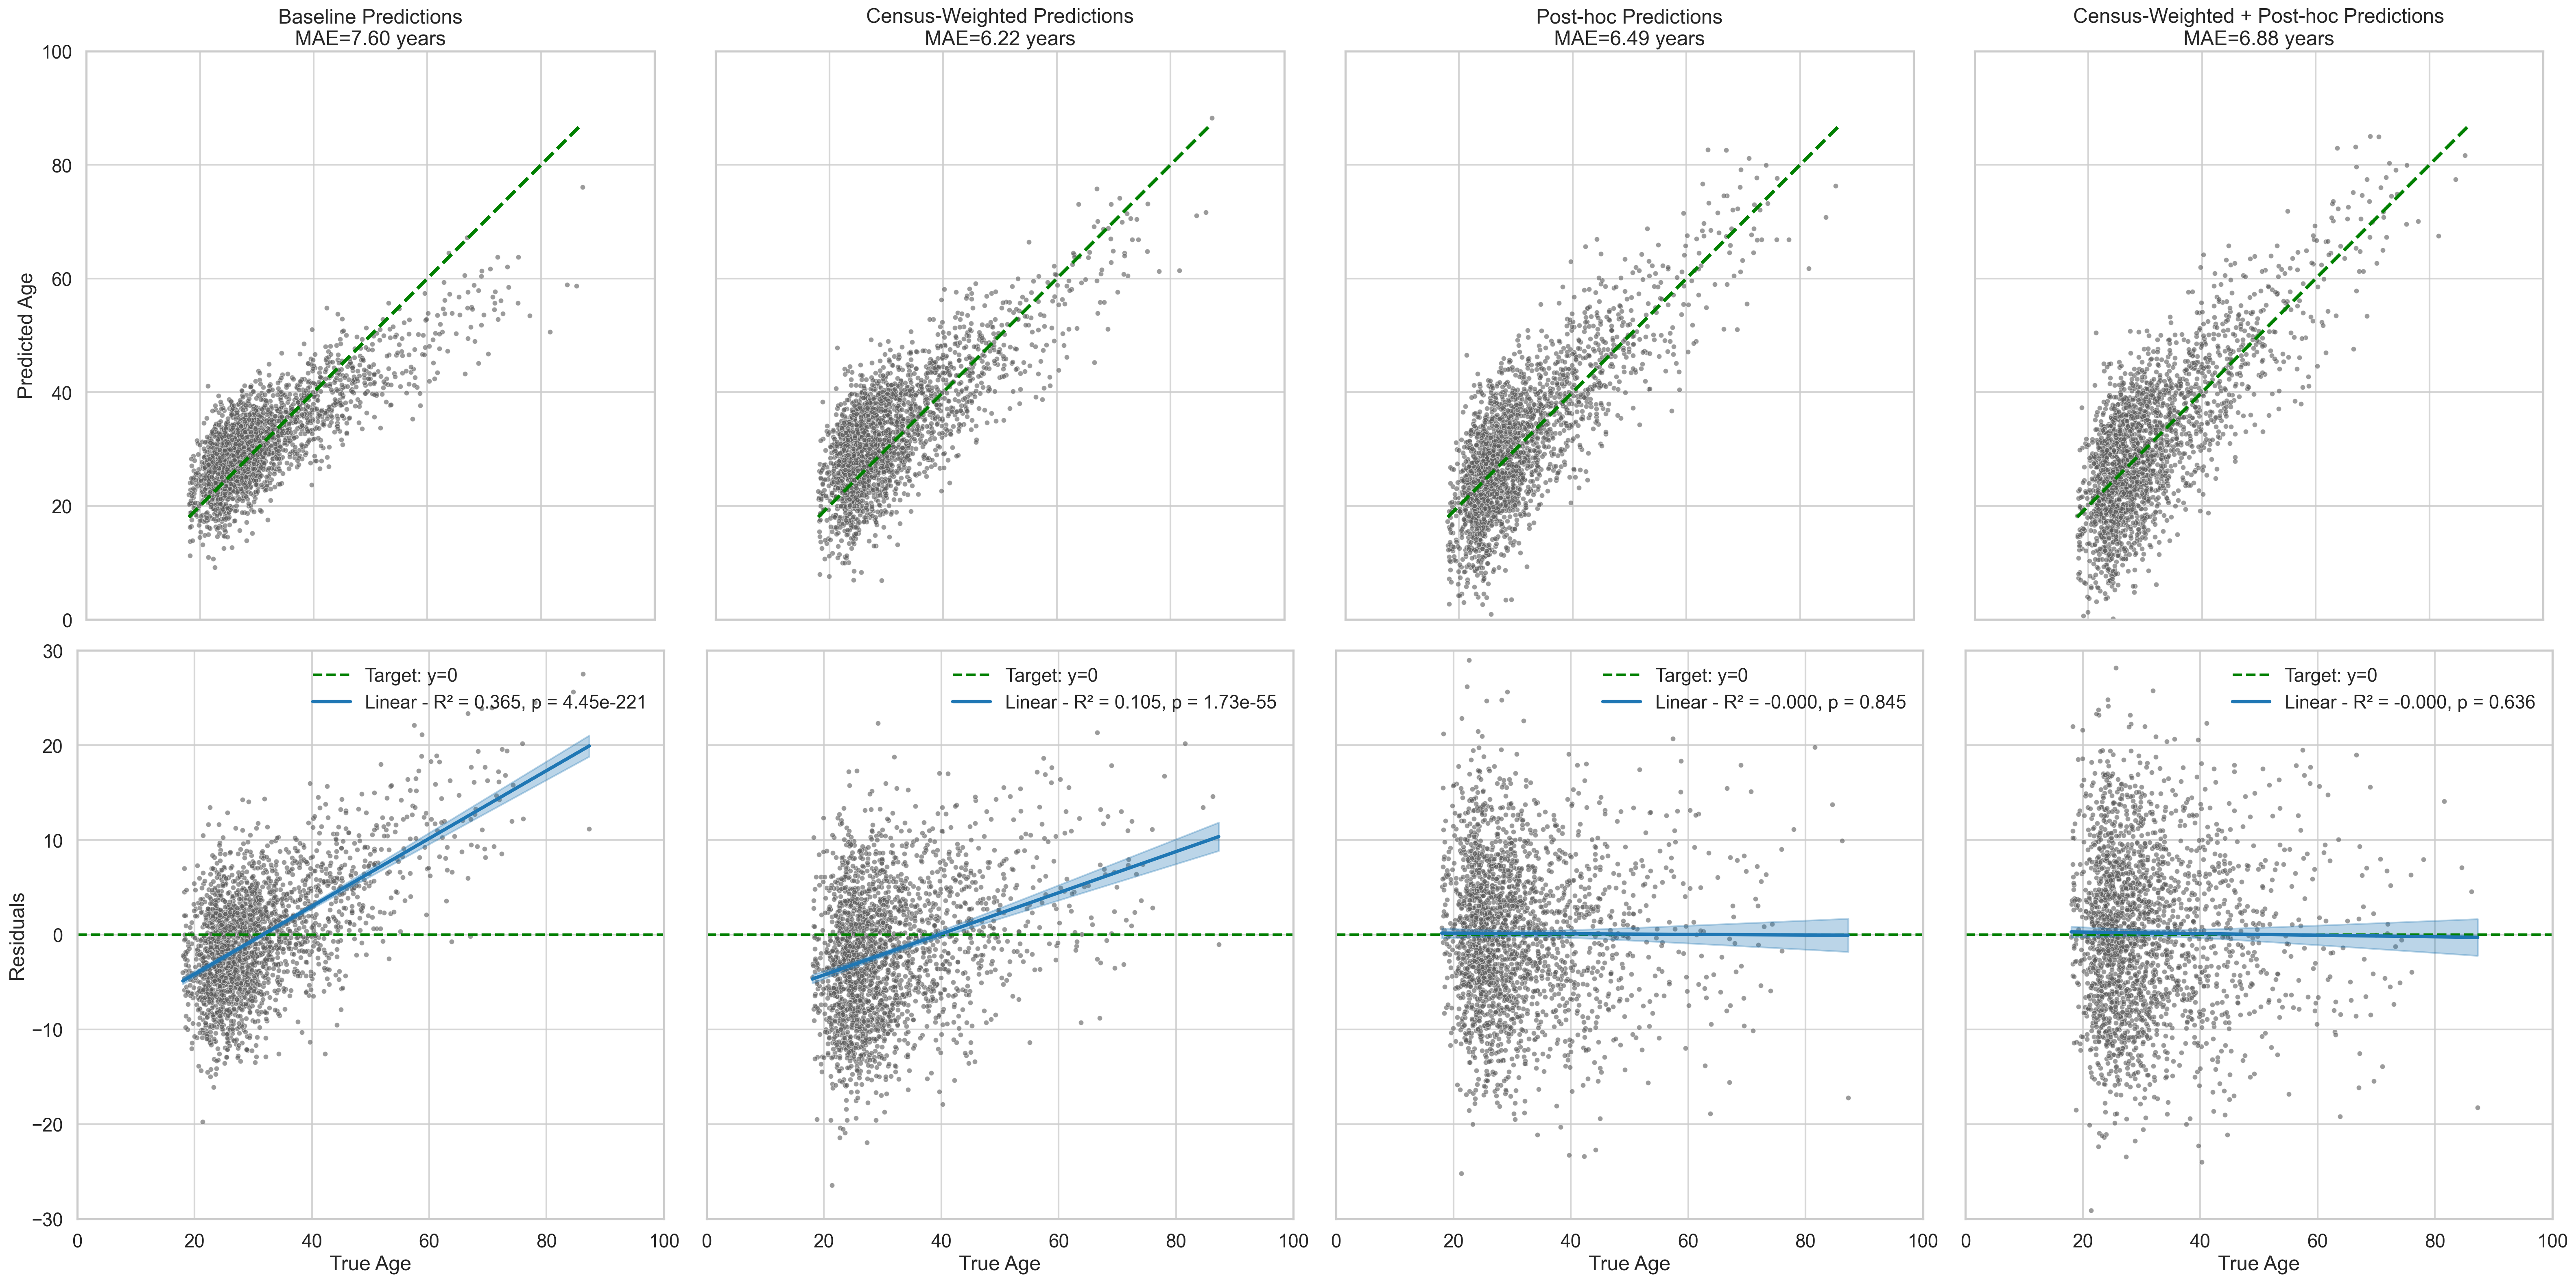

In [224]:
# plot actual vs predicted for all of the models
# plot residuals vs age for all of the models
from statsmodels.formula.api import ols
import statsmodels.api as sm

keys_vis = {
    "baseline": "Baseline",
    "weighted": "Census-Weighted",
    "linear_ph": "Post-hoc",
    "quadratic_ph": "Quadratic Post-hoc",
    "combined": "Census-Weighted + Post-hoc"
}

nmodels = len(weighting_predictions)
fig,axes = plt.subplots(2, nmodels, figsize=(8*nmodels, 16), sharey=False, sharex=True)
for i, (key, df) in enumerate(weighting_predictions.items()):
    ax = axes[0,i]
    sns.scatterplot(data=df, x="True", y="Predicted", ax=ax, s=20, color=COL_REF, alpha=0.6)
    ax.set_title(f"{keys_vis[key]} Predictions\nMAE={weighting_df.loc[key, 'MAE_weighted']:.2f} years")
    ax.set_aspect("equal")
    ax.set_xlabel("")
    ax.plot([df["True"].min(), df["True"].max()], [df["True"].min(), df["True"].max()], color="green", linestyle="--", lw=3)
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    if i == 0:
        ax.set_ylabel("Predicted Age")
    else:
        ax.set_ylabel("")
        # remove y-axis tick labels
        ax.set_yticklabels([])


for i, (key, df) in enumerate(weighting_predictions.items()):
    ax = axes[1, i]
    if "ph" in key:
        y_col = "corrected_residuals"
    else:
        df["raw_residuals"] = df["True"] - df["Predicted"]
        y_col = "raw_residuals"
    df = df.rename(columns={"True": "age_at_scan"})
    sns.scatterplot(data=df, x="age_at_scan", y=y_col, ax=ax, s=20, color=COL_REF, alpha=0.6)

    # estimate linear and quadratic fit between residuals and age
    lin_m = ols(f"{y_col} ~ age_at_scan", data=df).fit()
    poly_m = ols(f"{y_col} ~ age_at_scan + I(age_at_scan ** 2)", data=df).fit()
    # draw the "target": y = 0 line
    ax.axhline(0, color="green", linestyle="--", label="Target: y=0")
    # plot the linear fit
    x_vals = np.linspace(df["age_at_scan"].min(), df["age_at_scan"].max(), 300)
    x_frame = pd.DataFrame({"age_at_scan": x_vals})
    # find the p-value for the linear fit
    p_value = lin_m.f_pvalue
    # For visualisation, find the p < {something} value
    p_vis = f"{p_value:.2e}" if p_value < 0.001 else f"{p_value:.3f}"
    lin_label = f"Linear - R² = {lin_m.rsquared_adj:.3f}, p = {p_vis}"
    # get predictions with CI
    lin_predictions = lin_m.get_prediction(x_frame)
    lin_predictions = lin_predictions.summary_frame(alpha=0.05)
    # plot the linear fit with confidence intervals
    ax.plot(
        x_vals, lin_m.predict(x_frame), color=COL_RAW, label=lin_label, lw=3
    )
    ax.fill_between(
        x_vals,
        lin_predictions["mean_ci_lower"],
        lin_predictions["mean_ci_upper"],
        color=COL_RAW, alpha=0.3
    )
    # plot the quadratic fit
    # poly_label = f"Quadratic - R² = {poly_m.rsquared:.2f}, AIC = {poly_m.aic:.1f}"
    # get predictions with CI
    # poly_predictions = poly_m.get_prediction(x_frame)
    # poly_predictions = poly_predictions.summary_frame(alpha=0.05)
    # plot the quadratic fit with confidence intervals
    # ax.plot(
    #     x_vals, poly_m.predict(x_frame), color=COL_WEIGHTED, label=poly_label, lw=3
    # )
    # ax.fill_between(
    #     x_vals,
    #     poly_predictions["mean_ci_lower"],
    #     poly_predictions["mean_ci_upper"],
    #     color=COL_WEIGHTED, alpha=0.3
    # )
    # ax.set_title(f"{keys_vis[key]} Residuals\nMAE={weighting_df.loc[key, 'MAE_weighted']:.2f} years")
    ax.legend(frameon=False, loc="upper right")

    ax.set_xlabel("True Age")
    if i == 0:
        ax.set_ylabel("Residuals")
    else:
        ax.set_ylabel("")
        # remove y-axis tick labels
        ax.set_yticklabels([])
    ax.set_ylim(-30, 30)

    # ax.set_xlim(df["age_at_scan"].min(), df["age_at_scan"].max())
    # ax.legend(frameon=False)
plt.tight_layout()

In [225]:
import numpy as np, pandas as pd
from sklearn.linear_model import RidgeCV, ElasticNetCV
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

alphas = np.logspace(-3, 4, 30)  # ridge λ grid

outer_cv = KFold(
    n_splits=10,
    shuffle=True,
    random_state=1,
)

perf_rows = []

use_weights = False
# do_post_hoc_correction = True
post_hoc_degree = 1

predictions = {}

for metric, X in X_dict.items():
    # Optionally concatenate covariates
    covariates = cov_names[metric]
    if cov_names:
        X_model = np.hstack([X, cov[covariates].to_numpy()])
    else:
        X_model = X
    # y_pred = stratified_regression_cv(X_model, y, w, n_splits=10, n_bins=10)

    # # Model & CV (same ridge code as before)
    model = Pipeline([
        ("scaler", scaler),
        ("estimator", estimator),
    ])

    y_pred, original_residuals, corrected_residuals = cross_val_predict_with_bias_correction(
        model=model,
        X=X_model,
        y_chronological=y,
        w=w,
        cv=outer_cv,
        use_weights=use_weights,
        post_hoc_degree=post_hoc_degree,
        # residual_orthog_degree=post_hoc_degree,
    )

    # y_pred = cross_val_predict(
    #     model,
    #     X_model,
    #     y,
    #     # groups=age_strata(y),
    #     cv=outer_cv,
    #     params={"estimator__sample_weight": w if use_weights else None},
    #     n_jobs=-1,
    # )
    # if do_post_hoc_correction:
    #     resid = y - y_pred
    #     z = np.polyfit(y, resid, 2)
    #     p = np.poly1d(z)
    #     y_pred = y_pred + p(y)
    # # Save predictions
    predictions_df = cov.copy()
    predictions_df["True"] = y
    predictions_df["Predicted"] = y_pred
    predictions_df["raw_residuals"] = original_residuals
    predictions_df["corrected_residuals"] = corrected_residuals
    predictions[metric] = predictions_df
    perf_rows.append(
        dict(
            metric=metric,
            # R2=r2_score(y, y_pred, sample_weight=w if use_weights else None),
            # MAE=mean_absolute_error(y, y_pred, sample_weight=w if use_weights else None),
            # RMSE=root_mean_squared_error(y, y_pred, sample_weight=w if use_weights else None),
            R2=r2_score(y, y_pred),
            R2_weighted=r2_score(y, y_pred, sample_weight=w),
            MAE=mean_absolute_error(y, y_pred),
            MAE_weighted=mean_absolute_error(y, y_pred, sample_weight=w),
            RMSE=root_mean_squared_error(y, y_pred),
            RMSE_weighted=root_mean_squared_error(y, y_pred, sample_weight=w)
        )
    )
    # break

In [226]:
# compare between linear and quadratic association between raw residuals and age
m = "gm_vol"
predictions_df = predictions[m].copy().rename(columns={"True":"age_at_scan"})
# linear
lin_mod = ols("raw_residuals ~ age_at_scan", data=predictions_df).fit()
# quadratic
quad_mod = ols("raw_residuals ~ age_at_scan + I(age_at_scan ** 2)", data=predictions_df).fit()
print(f"Linear model R²: {lin_mod.rsquared:.3f}")
print(f"Linear model AIC: {lin_mod.aic:.3f}")
print(f"Quadratic model R²: {quad_mod.rsquared:.3f}")
print(f"Quadratic model AIC: {quad_mod.aic:.3f}")

# sns.scatterplot(data=predictions[m], x="True", y="raw_residuals")
# sns.scatterplot(data=predictions[m], x="True", y="corrected_residuals")

Linear model R²: 0.365
Linear model AIC: 13315.162
Quadratic model R²: 0.369
Quadratic model AIC: 13305.349


6.46485708290108
0.32284013169318937


(0.0, 100.0)

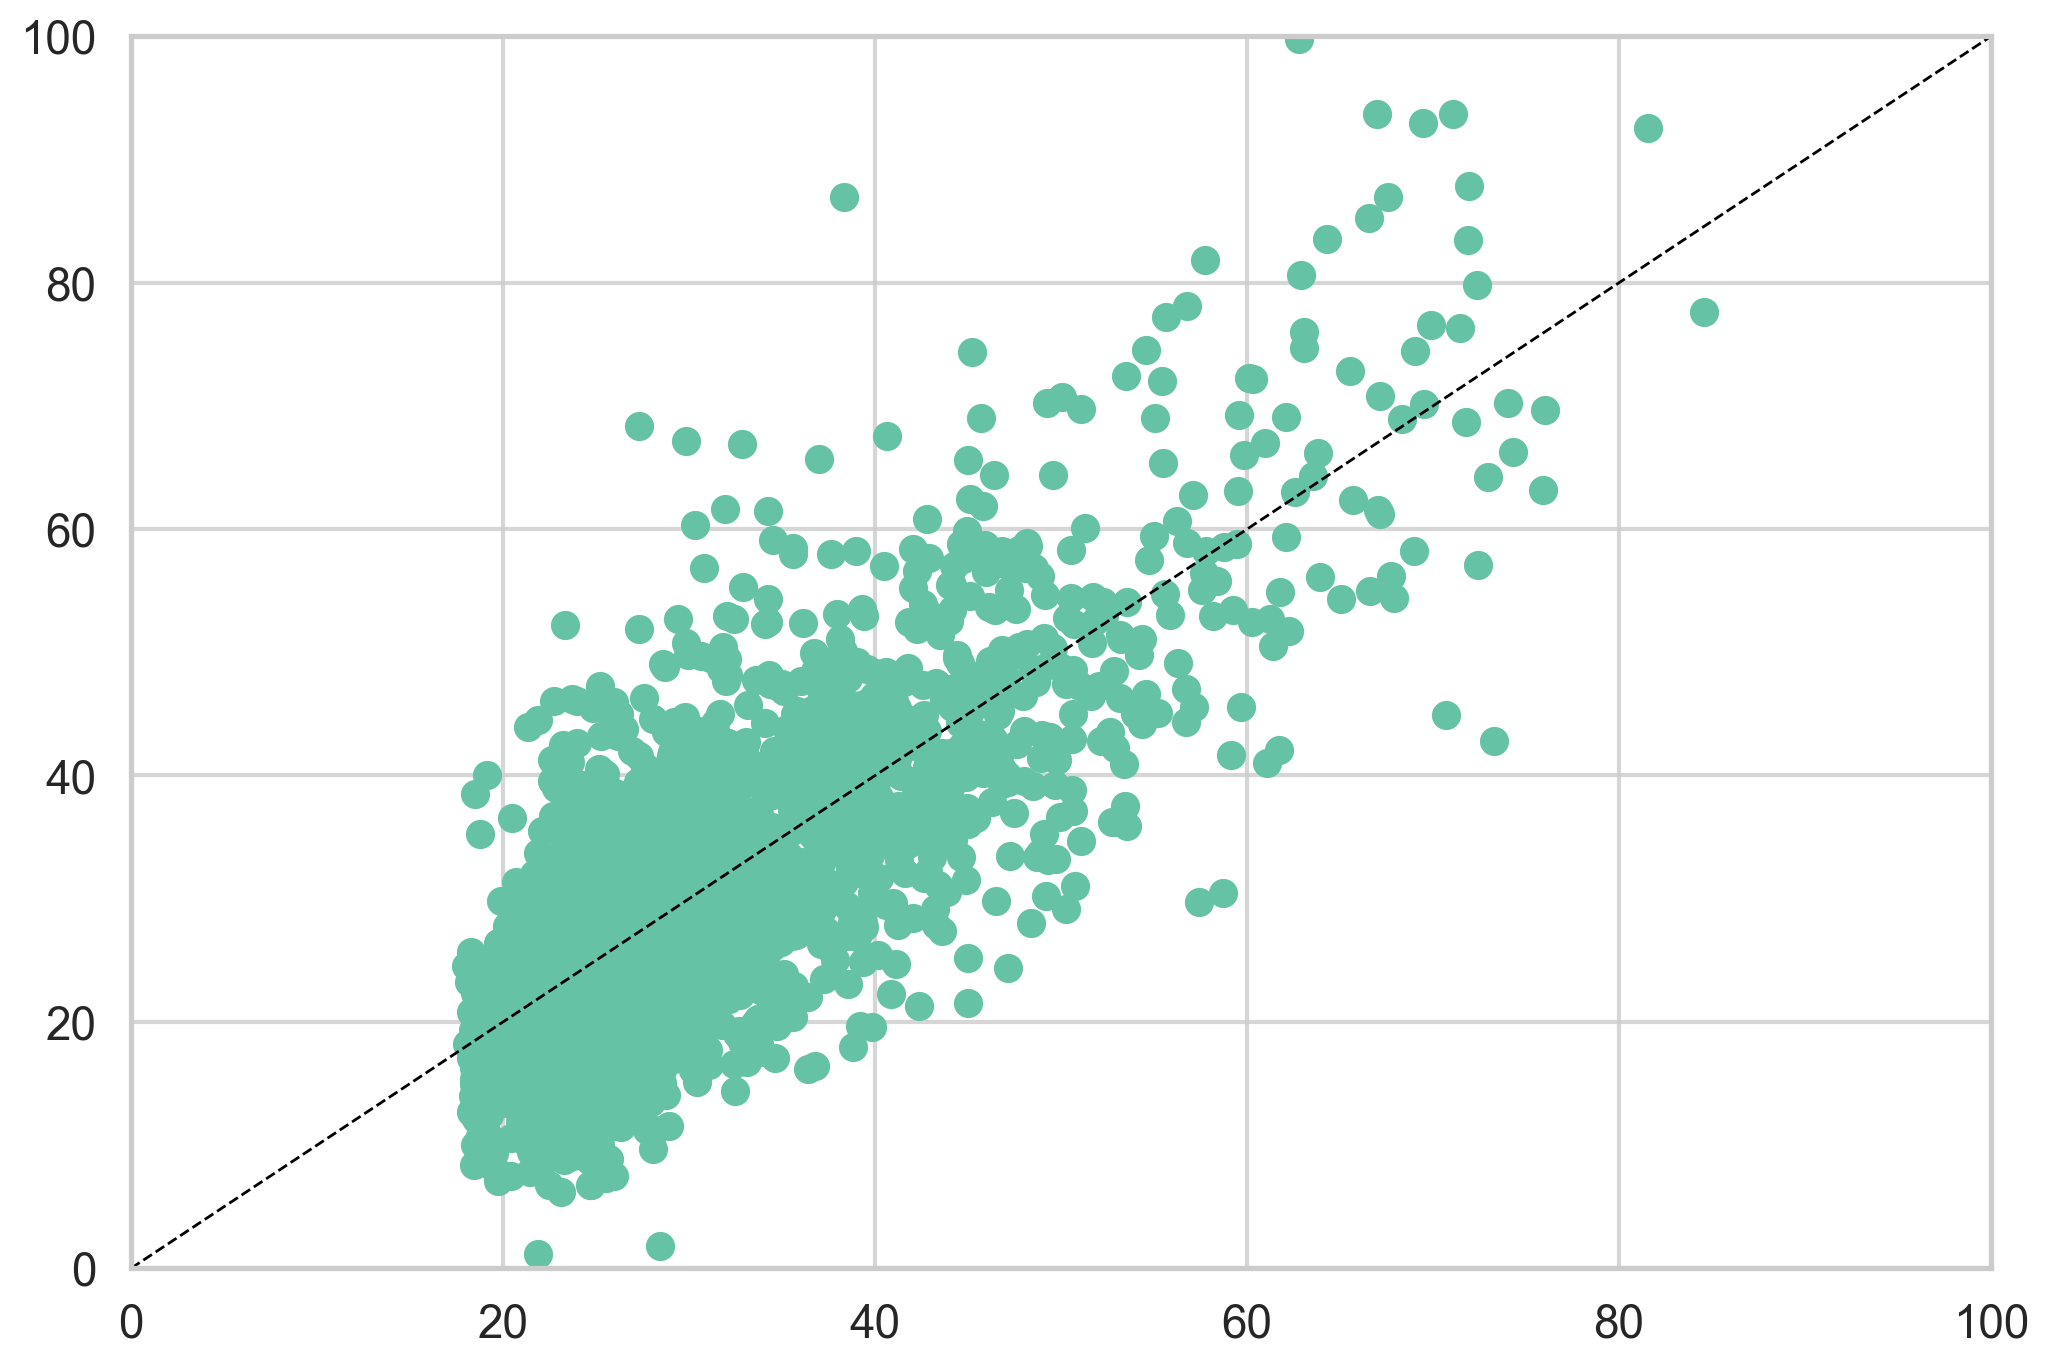

In [227]:
print(mean_absolute_error(y, y_pred, sample_weight=w if use_weights else None))
print(r2_score(y, y_pred, sample_weight=w if use_weights else None))
plt.scatter(y, y_pred)
plt.plot([0, 100], [0, 100], color="black", linestyle="--", linewidth=1)
plt.xlim(0, 100)
plt.ylim(0, 100)

In [228]:
from scipy.stats import spearmanr

spearmanr(predictions["gm_vol"]["True"], predictions["gm_vol"]["corrected_residuals"])


SignificanceResult(statistic=np.float64(-0.031301752334329254), pvalue=np.float64(0.1406502857470834))

In [229]:
pd.DataFrame(perf_rows).set_index("metric")

R2  R2_weighted       MAE  MAE_weighted      RMSE  RMSE_weighted
metric                                                                        
gm_vol  0.451987     0.811983  6.081101      6.489799  7.641034       8.101839
adc     0.325666     0.652915  6.430406      8.310670  8.476066      11.007859
fa      0.444609     0.676618  5.907656      7.624946  7.692300      10.625332
ad      0.391041     0.683908  6.039793      7.791973  8.054725      10.504887
rd      0.322840     0.649946  6.464857      8.303878  8.493807      11.054831

In [231]:
pd.DataFrame(perf_rows).set_index("metric").sort_values("MAE_weighted", ascending=True)

R2  R2_weighted       MAE  MAE_weighted      RMSE  RMSE_weighted
metric                                                                        
gm_vol  0.451987     0.811983  6.081101      6.489799  7.641034       8.101839
fa      0.444609     0.676618  5.907656      7.624946  7.692300      10.625332
ad      0.391041     0.683908  6.039793      7.791973  8.054725      10.504887
rd      0.322840     0.649946  6.464857      8.303878  8.493807      11.054831
adc     0.325666     0.652915  6.430406      8.310670  8.476066      11.007859

In [232]:
### ----------- Concatenate all metrics into one model ----------- ###
from sklearn.pipeline import make_pipeline

X_concat = np.hstack([X_dict[m] for m in metrics])  # already row-aligned
# add covariates
covariates = pd.concat([cov[cov_names[m]] for m in metrics], axis=1)
# drop duplicate columns
covariates = covariates.loc[:, ~covariates.columns.duplicated()].to_numpy()
X_concat = np.hstack([X_concat, covariates])

pipe = Pipeline(
    [
        ("scaler", scaler),
        ("estimator", estimator),
    ]
)
y_pred, original_residuals, corrected_residuals = cross_val_predict_with_bias_correction(
    model=pipe,
    X=X_concat,
    y_chronological=y,
    w=w,
    cv=outer_cv,
    use_weights=use_weights,
    post_hoc_degree=post_hoc_degree,
    # residual_orthog_degree=post_hoc_degree,
)

# if do_post_hoc_correction:
#     resid = y - y_pred
#     z = np.polyfit(y, resid, 2)
#     p = np.poly1d(z)
#     y_pred = y_pred + p(y)
# # Save predictions
predictions_df = cov.copy()
predictions_df["True"] = y
predictions_df["Predicted"] = y_pred
predictions_df["raw_residuals"] = original_residuals
predictions_df["corrected_residuals"] = corrected_residuals
predictions["concatenated"] = predictions_df
perf_rows.append(
    dict(
        metric="concatenated",
        R2=r2_score(y, y_pred),
        R2_weighted=r2_score(y, y_pred, sample_weight=w),
        MAE=mean_absolute_error(y, y_pred),
        MAE_weighted=mean_absolute_error(y, y_pred, sample_weight=w),
        RMSE=root_mean_squared_error(y, y_pred),
        RMSE_weighted=root_mean_squared_error(y, y_pred, sample_weight=w),
    )
)

In [244]:
# polynomial features
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
# ---------------------------------------------------------------------
# 2. Parcel-wise base-learner loop
# ---------------------------------------------------------------------
stacked_models = parcels.copy()

stacked_estimators = {}
predictions["base_stacked"] = {}

alphas = np.logspace(-3, 4, 30)  # ridge grid
for i, row in parcels.iterrows():  # i == parcel index (0..453)
    # ------------- build design matrix for parcel i -----------------
    # X_roi : (n_subjects , 5 metrics)
    X_roi = np.hstack([X_dict[m][:, [i]] for m in metrics])

    pipe = Pipeline(
        steps=[
            ("scaler", StandardScaler()),
            ("poly", PolynomialFeatures(degree=2)),
            ("estimator", RidgeCV(alphas=alphas)),
            # ("estimator", RandomForestRegressor())
        ]
    )

    # ---------------- fit model & predict --------------------------
    y_pred, original_residuals, corrected_residuals = cross_val_predict_with_bias_correction(
        model=pipe,
        X=X_roi,
        y_chronological=y,
        w=w,
        cv=outer_cv,
        use_weights=use_weights,
        post_hoc_degree=post_hoc_degree,
        # residual_orthog_degree=post_hoc_degree,
    )

    # ---------------- store predictions & metrics -------------------
    pred_df = cov.copy()
    pred_df["True"] = y
    pred_df["Predicted"] = y_pred
    pred_df["raw_residuals"] = original_residuals
    pred_df["corrected_residuals"] = corrected_residuals
    predictions["base_stacked"][i] = pred_df
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    rmse = root_mean_squared_error(y, y_pred)
    r2_weighted = r2_score(y, y_pred, sample_weight=w)
    mae_weighted = mean_absolute_error(y, y_pred, sample_weight=w)
    rmse_weighted = root_mean_squared_error(y, y_pred, sample_weight=w)

    stacked_models.loc[i, ["R2", "MAE", "RMSE", "R2_weighted", "MAE_weighted", "RMSE_weighted"]] = [
        r2, mae, rmse, r2_weighted, mae_weighted, rmse_weighted
    ]
    stacked_estimators[i] = pipe

<Axes: >

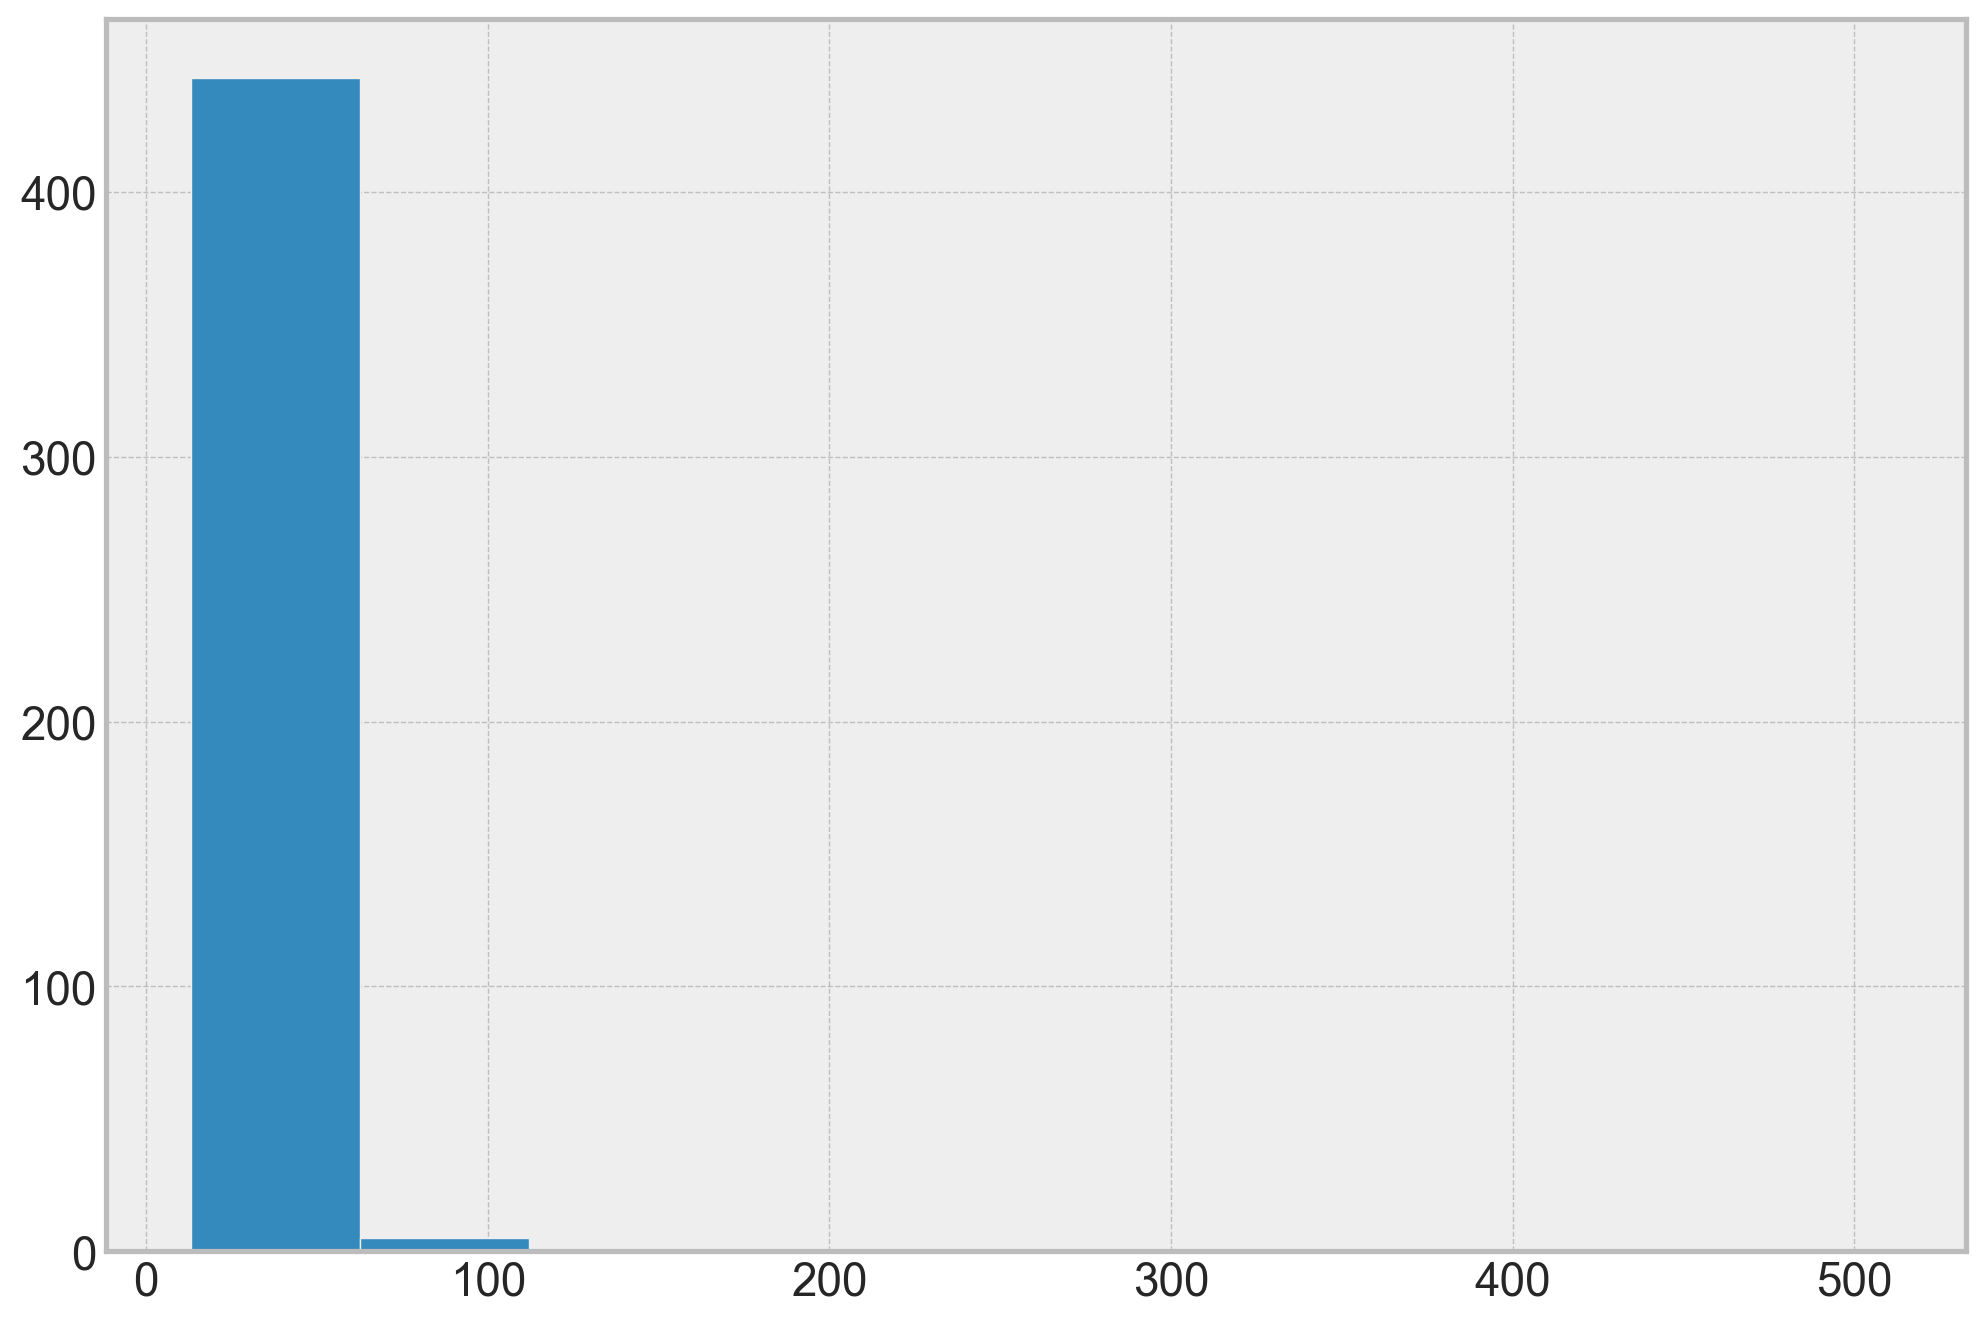

In [246]:
stacked_models["MAE_weighted"].hist()
# stacked_models.sort_values("MAE_weighted", ascending=False)

In [247]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
)

# ------------------------------------------------------------------
# 1.  Build the meta-feature matrix  (n_subj × n_parcels [+ covariates])
# ------------------------------------------------------------------
# stack parcel OOF columns → shape (454, n_subj) → transpose
X_stacked = np.vstack(
    [predictions["base_stacked"][i]["Predicted"].to_numpy() for i in predictions["base_stacked"]]
).T  # (n_subj, n_parcels)

# Optionally add covariates (e.g., sex, TIV)
X_stacked = np.hstack([X_stacked, covariates])

# ------------------------------------------------------------------
# 2.  Meta-learner pipeline (standardised ridge with CV on λ)
# ------------------------------------------------------------------
pipe = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("estimator", RidgeCV(alphas=alphas)),
    ]
)

# ------------------------------------------------------------------
# 3.  Out-of-fold meta predictions with fold-wise bias correction
# ------------------------------------------------------------------
y_pred, original_residuals, corrected_residuals = cross_val_predict_with_bias_correction(
    model=pipe,
    X=X_stacked,
    y_chronological=y,
    w=w,
    cv=outer_cv,
    use_weights=use_weights,
    post_hoc_degree=post_hoc_degree,
    # residual_orthog_degree=post_hoc_degree,
)

# ------------------------------------------------------------------
# 4.  Store predictions and performance
# ------------------------------------------------------------------
pred_df = cov.copy()
pred_df["True"] = y
pred_df["Predicted"] = y_pred
pred_df["raw_residuals"] = original_residuals
pred_df["corrected_residuals"] = corrected_residuals
predictions["stacked"] = pred_df


perf_rows.append(
    dict(
        metric="stacked",
        R2=r2_score(y, y_pred),
        R2_weighted=r2_score(y, y_pred, sample_weight=w),
        MAE=mean_absolute_error(y, y_pred),
        MAE_weighted=mean_absolute_error(y, y_pred, sample_weight=w),
        RMSE=root_mean_squared_error(y, y_pred),
        RMSE_weighted=root_mean_squared_error(y, y_pred, sample_weight=w),
    )
)

In [251]:
dict(
    metric="stacked",
    R2=r2_score(y, y_pred),
    R2_weighted=r2_score(y, y_pred, sample_weight=w),
    MAE=mean_absolute_error(y, y_pred),
    MAE_weighted=mean_absolute_error(y, y_pred, sample_weight=w),
    RMSE=root_mean_squared_error(y, y_pred),
    RMSE_weighted=root_mean_squared_error(y, y_pred, sample_weight=w),
)

{'metric': 'stacked',
 'R2': 0.5095734134035026,
 'R2_weighted': 0.49397591675605634,
 'MAE': 4.971730967893435,
 'MAE_weighted': 7.913367983033972,
 'RMSE': 7.22842707412007,
 'RMSE_weighted': 13.291392265088637}

In [253]:
perf_df = pd.DataFrame(perf_rows).set_index("metric").sort_values("MAE_weighted", ascending=True)

In [254]:
perf_df

R2  R2_weighted       MAE  MAE_weighted      RMSE  \
metric                                                                  
concatenated  0.702180     0.864056  4.305982      5.268561  5.632925   
gm_vol        0.451987     0.811983  6.081101      6.489799  7.641034   
stacked       0.426843     0.631769  5.649019      7.527667  7.814363   
fa            0.444609     0.676618  5.907656      7.624946  7.692300   
ad            0.391041     0.683908  6.039793      7.791973  8.054725   
stacked       0.509573     0.493976  4.971731      7.913368  7.228427   
rd            0.322840     0.649946  6.464857      8.303878  8.493807   
adc           0.325666     0.652915  6.430406      8.310670  8.476066   

              RMSE_weighted  
metric                       
concatenated       6.889126  
gm_vol             8.101839  
stacked           11.338227  
fa                10.625332  
ad                10.504887  
stacked           13.291392  
rd                11.054831  
adc               11.007859

/tmp/ipykernel_123201/3097642519.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="metric",x = "MAE_weighted", data=perf_df.reset_index(), palette="Set2", ax=ax, orient="h")


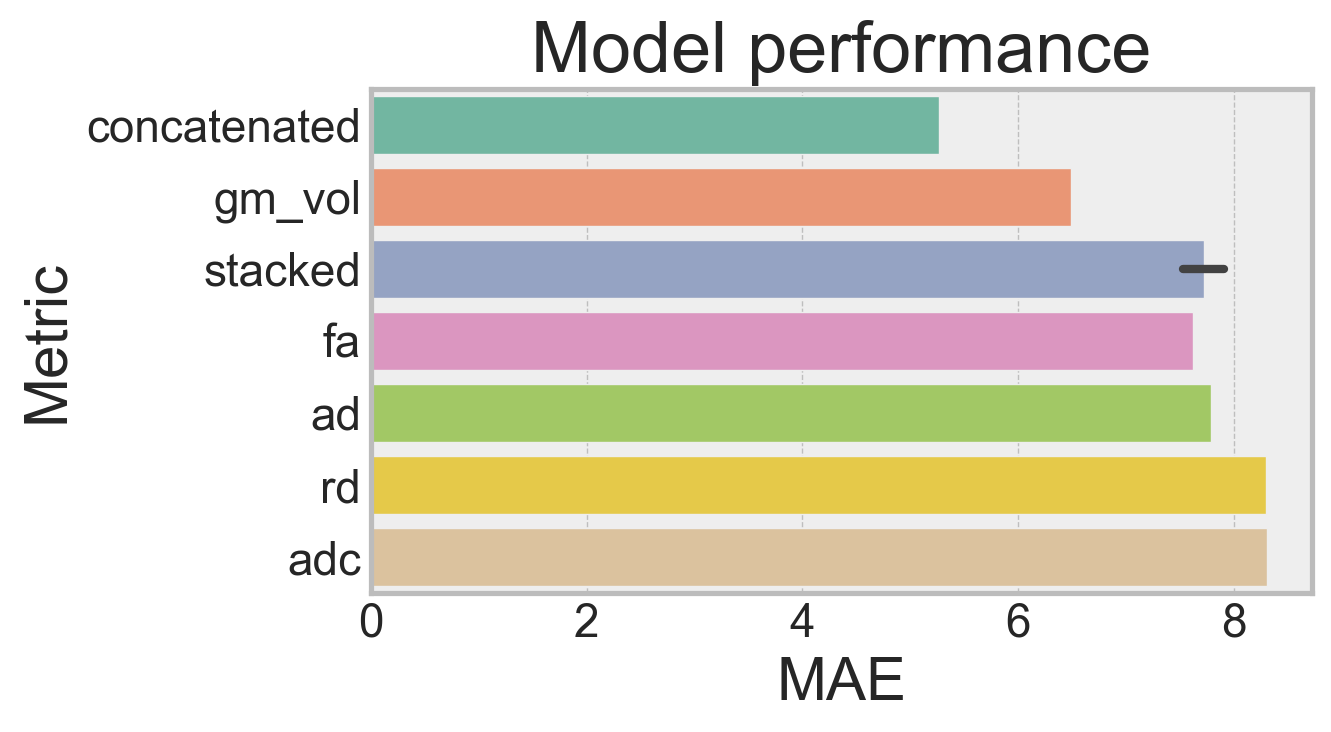

In [255]:
# -----------------------------------------------------------
# 2.  barplot with 95 % BCa bootstrap CIs on R²
# -----------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample


# def bca_ci(arr, stat_func=np.mean, n_boot=10000, alpha=0.05):
#     """BCa bootstrap CI for a 1-D array."""
#     boot_stats = [stat_func(resample(arr)) for _ in range(n_boot)]
#     lo, hi = np.percentile(boot_stats, [100 * alpha / 2, 100 * (1 - alpha / 2)])
#     return lo, hi


# ci_lo, ci_hi = [], []
# for m in perf_df.index:
#     # resample over subjects to get CI on R²
#     errs = y - X_dict[m].dot(np.ones(X_dict[m].shape[1]))  # dummy just to get shape
#     lo, hi = bca_ci(perf_df.loc[m, ["R2"]].values)
#     ci_lo.append(lo)
#     ci_hi.append(hi)

fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(y="metric",x = "MAE_weighted", data=perf_df.reset_index(), palette="Set2", ax=ax, orient="h")
# ax.errorbar(
#     x=np.arange(len(perf_df)),
#     y=perf_df["RMSE"],
#     # yerr=[perf_df["R2"] - ci_lo, ci_hi - perf_df["R2"]],
#     fmt="none",

#     capsize=4,
#     color="k",
#     lw=1,
# )
# ax.set_ylabel("$R^{2}$  (10× CV, bias-corrected)")
ax.set_xlabel("MAE")
ax.set_ylabel("Metric")
ax.set_title("Model performance")
# ax.set_xticks(np.arange(0, 1.1, 0.1))
# ax.set_ylim(0.8, perf_df["R2"].max() * 1.15)
plt.tight_layout()
# ax.set_xlim(3,6)
# plt.savefig("metric_comparison_bias_corrected.png", dpi=400)
plt.show()

In [176]:
best_metric = perf_df.index[0]
# best_metric = "gm_vol"
y = predictions[best_metric]["True"].to_numpy()
y_pred = predictions[best_metric]["Predicted"].to_numpy()
# w = predictions[best_metric]["weight"].to_numpy()
df = predictions[best_metric][["True","Predicted"]].copy().rename(columns={"True": "age", "Predicted": "predicted"})

df["residuals"] = df["age"] - df["predicted"]
# # build a model to predict the residuals
# import statsmodels.api as sm
# from statsmodels.formula.api import ols
# import statsmodels.formula.api as smf

# # Fit a linear model to the residuals
# df["residuals"] = residuals
# model = ols("residuals ~ age", data=df).fit()
# # use the model to "fix" the predictions
# df["fixed_predicted"] = df["predicted"] + model.resid

ValueError: Could not interpret value `age` for `x`. An entry with this name does not appear in `data`.

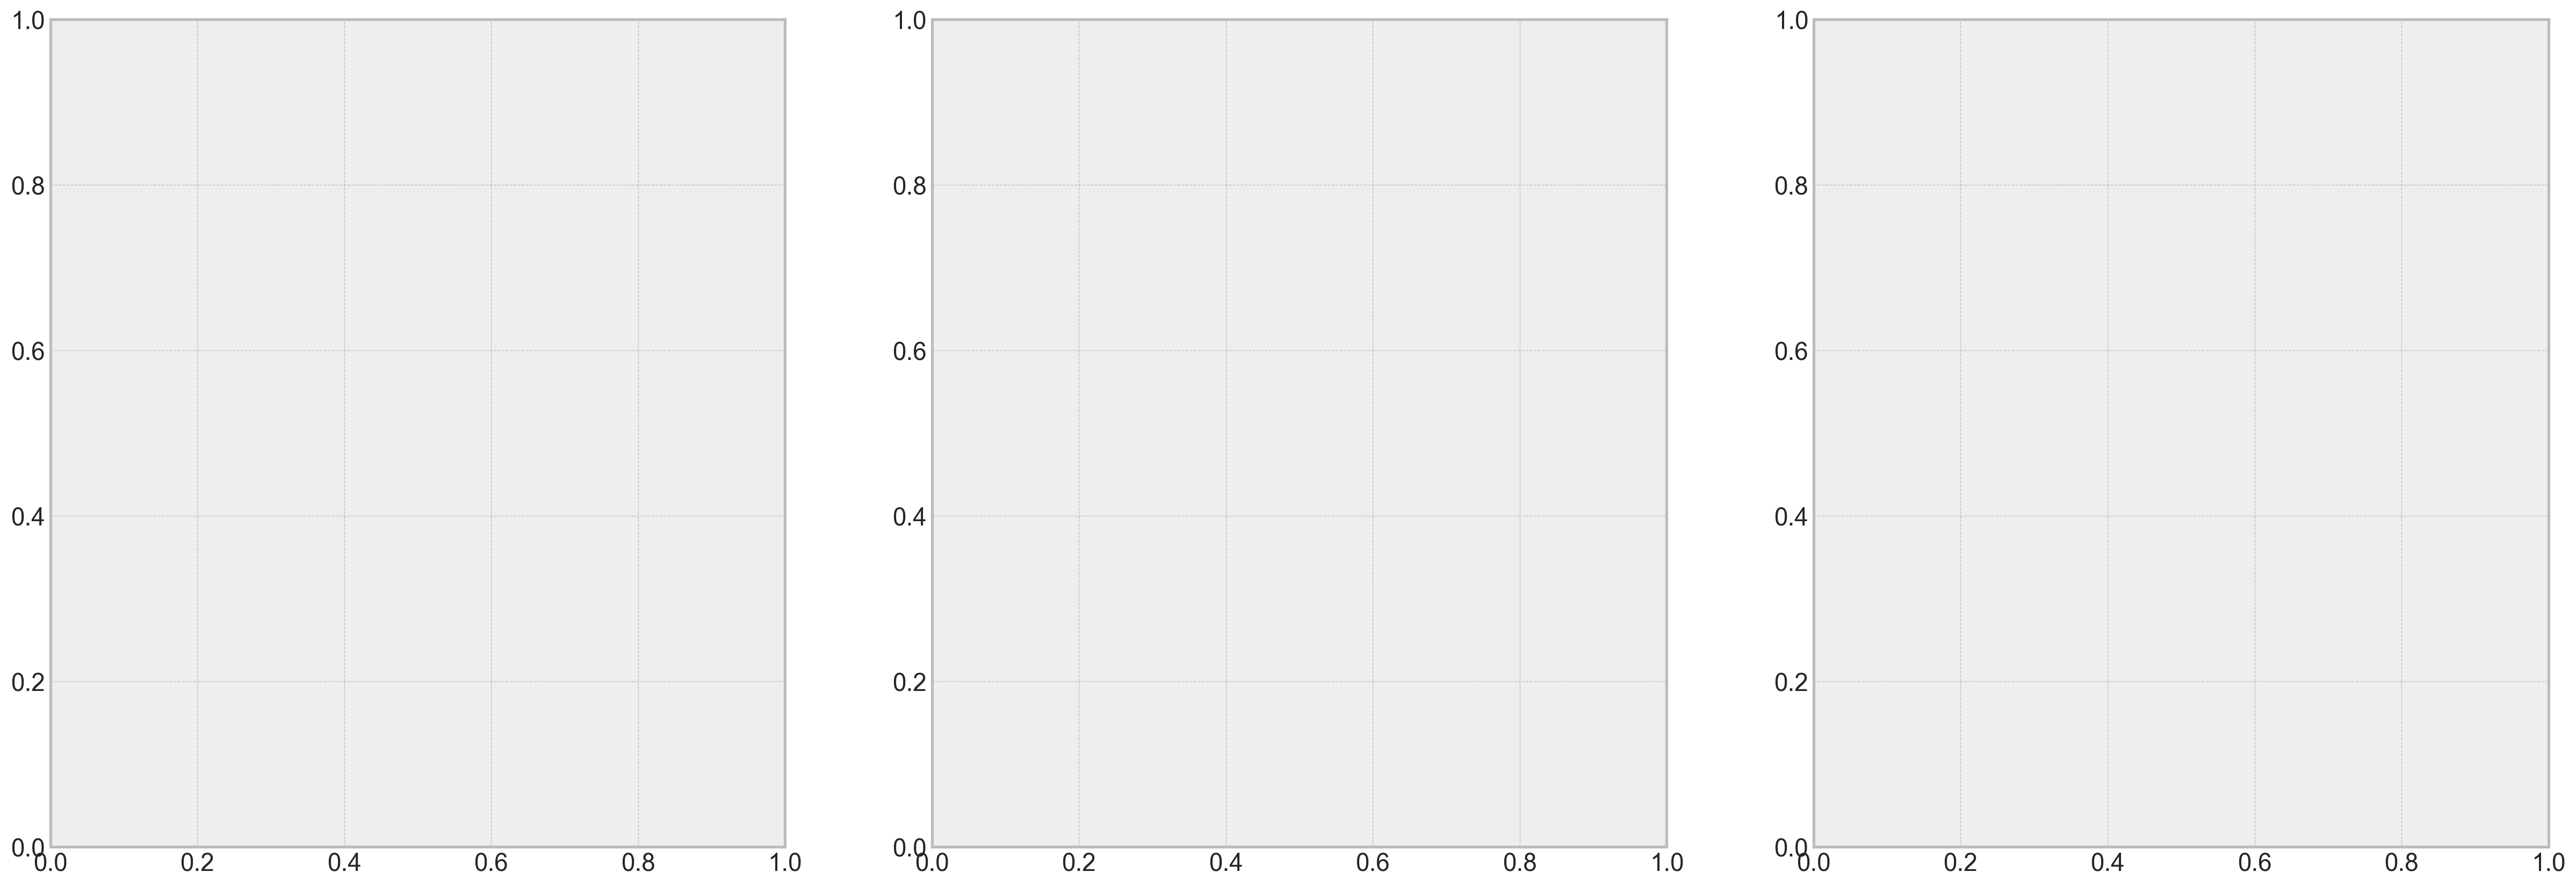

In [239]:
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

plt.style.use("bmh")


r2 = r2_score(y, y_pred, sample_weight=w if use_weights else None)
rmse = root_mean_squared_error(y, y_pred, sample_weight=w if use_weights else None)
mae = mean_absolute_error(y, y_pred, sample_weight=w if use_weights else None)

# r2 = r2_score(y, y_pred)
# rmse = root_mean_squared_error(y, y_pred)
# mae = mean_absolute_error(y, y_pred)


title = f"True vs Predicted Age\nRMSE: {rmse:.2f}, R2: {r2:.2f}, MAE: {mae:.2f}"

fig, axes = plt.subplots(1, 3, figsize=(30, 10))
# plot true vs predicted
ax = axes[0]
sns.scatterplot(
    data=df,
    x="age",
    y="predicted",
    ax=ax,
    # cmap="jet",
    # color by weight,
    # hue=w.flatten(),
    palette="viridis",
    s=w * 10,
)
ax.plot([18, 100], [18, 100], "--", c="red")
ax.set_xlabel("True Age", fontsize=24)
ax.set_ylabel("Predicted Age", fontsize=24)
ax.set_title(title, fontsize=30)
ax.set_xticks(range(20, 100, 10))
ax.set_yticks(range(20, 100, 10))
# make axis square
ax.set_aspect("equal", "box")

# plot residuals
ax = axes[1]
sns.histplot(data=df,x="residuals", ax=ax, kde=True, color="black")
ax.set_xlabel("Residuals", fontsize=24)
ax.set_ylabel("Density", fontsize=24)
ax.set_title("Residuals", fontsize=30)
ax.axvline(0, color="red", linestyle="--")

# plot residuals vs true age

r, p = spearmanr(df["age"], df["residuals"])

ax = axes[2]
sns.scatterplot(
    data=df,
    x="age",
    y="residuals",
    ax=ax,
    # cmap="jet",
    # color by weight,
    # hue=w.flatten(),
    palette="viridis",
    s=w*10,
)
ax.axhline(0, color="red", linestyle="--")
ax.set_xlabel("Age (years)", fontsize=24)
ax.set_ylabel("Residuals", fontsize=24)
ax.set_title("Residuals vs True Age\nρ = {:.2f}, p = {:.2g}".format(r, p), fontsize=30)
ax.set_xticks(range(20, 100, 10))
ax.set_yticks(range(-20, 20, 5))
# make axis square

suptitle = "Weighted Regression" if use_weights else "Unweighted Regression"
if do_post_hoc_correction:
    suptitle += " (+ Post-hoc correction)"
fig.suptitle(suptitle, fontsize=30)

plt.tight_layout()

In [178]:
df.sort_values("residuals", ascending=False).head(10)

age  predicted  residuals
subject_code                             
BB00634       58.71  40.994021  17.715979
BB00776       23.19   5.844071  17.345929
BB01126       24.86   7.909761  16.950239
AGN04         61.73  44.957450  16.772550
BB01153       22.70   6.125622  16.574378
0501          47.27  30.896607  16.373393
0973          39.85  23.615046  16.234954
AGN09         57.41  41.334403  16.075597
BB00200       29.19  13.804380  15.385620
1192          33.13  17.896723  15.233277

In [179]:
# df_cov = pd.read_pickle(f"/media/storage/phd/papers/aging/{ATLAS}/gm_vol.pkl").reset_index(
#     drop=True
# )
# df_cov = pd.read_csv("~/Projects/plasticityhub/sessions.csv")
df_cov = pd.read_csv("qV1v.csv")

finished_subjects = (
    pd.read_csv("/media/storage/phd/papers/aging/schaefer2018tian2020_400_7/subjects.csv")
    .values.flatten()
    .tolist()
)
df_cov = df_cov[df_cov["Subject Code"].isin(finished_subjects)]

# df_cov = df_cov.groupby("subject_code").first()
df_cov = df_cov.merge(df, left_on="Subject Code", right_index=True, how="inner")

In [180]:
# # cov_df["timestamp"] =
# df_cov["session_timestamp"] = pd.to_datetime(df_cov["session_id"], format="%Y%m%d%H%M%S")
# df_cov["year"] = df_cov["session_timestamp"].dt.year
# df_cov["month"] = df_cov["session_timestamp"].dt.month
# df_cov["day"] = df_cov["session_timestamp"].dt.day

# df_cov["days_since_start"] = (
#     df_cov["session_timestamp"] - df_cov["session_timestamp"].min()
# ).dt.days


In [181]:
df_cov

Subject Code Scanned Contact Again? CI - Native Language CI - Ethnicity  \
2            0002     Yes            Yes               Polish  Ashkenazi Jew   
3            0003     Yes            Yes               Hebrew  Sephardic Jew   
4            0004     Yes            Yes               Arabic  Sephardic Jew   
5            0005     Yes            Yes               Polish  Ashkenazi Jew   
7            0007     Yes            NaN               Hebrew  Ashkenazi Jew   
...           ...     ...            ...                  ...            ...   
2230       YA1252     Yes            NaN               Hebrew  Ashkenazi Jew   
2231       YA1264     Yes            NaN               Hebrew  Ashkenazi Jew   
2232       YA1269     Yes            NaN               Hebrew  Ashkenazi Jew   
2235       YA1279     NaN            NaN              Russian  Ashkenazi Jew   
2239      BB01118     NaN            NaN               Hebrew  Ashkenazi Jew   

     CI - Political Orientation        CI - Religious Orientation  LongCovid  \
2                           NaN                               NaN        NaN   
3                           NaN                               NaN         No   
4                           NaN                               NaN        NaN   
5                           NaN                               NaN         No   
7                           NaN                               NaN        NaN   
...                         ...                               ...        ...   
2230                  Left-Wing                           Secular         No   
2231                  Left-Wing  Traditional - Not Very Religious         No   
2232                     Center                           Secular        Yes   
2235                Center-Left                           Secular  LongCovid   
2239                  Left-Wing  Traditional - Not Very Religious        Yes   

      FamiliyDiseaseHistory BloodSugar  ...          Unnamed: 50 Blood Suger  \
2                       2.0     Normal  ...         No Suffering   16.363636   
3                       3.0       High  ...      Minor Suffering    3.546099   
4                       0.0     Normal  ...      Major Suffering    7.189542   
5                       3.0     Normal  ...  Signfican Suffering    6.451613   
7                       1.0        Low  ...                  NaN         NaN   
...                     ...        ...  ...                  ...         ...   
2230                    1.0        NaN  ...                  NaN         NaN   
2231                    0.0     Normal  ...                  NaN         NaN   
2232                    2.0        NaN  ...                  NaN         NaN   
2235                    1.0        Low  ...                  NaN         NaN   
2239                    0.0        NaN  ...                  NaN         NaN   

         HLI.1 Family Disease Psychiatric Medication Unnamed: 56    age  \
2     9.404762       0.836538   54.455446  34.615385    6.250000  67.75   
3     9.327778       0.909871   56.768559  26.609442    6.270386  69.01   
4     9.337719       0.971223   58.736059  33.453237    6.082734  73.25   
5     9.558824       0.988372   56.470588  26.162791    6.058140  87.27   
7          NaN            NaN         NaN        NaN         NaN  78.01   
...        ...            ...         ...        ...         ...    ...   
2230       NaN            NaN         NaN        NaN         NaN  21.89   
2231       NaN            NaN         NaN        NaN         NaN  18.38   
2232       NaN            NaN         NaN        NaN         NaN  27.53   
2235       NaN            NaN         NaN        NaN         NaN  21.06   
2239       NaN            NaN         NaN        NaN         NaN  28.87   

      predicted  residuals  
2     63.148850   4.601150  
3     69.134321  -0.124321  
4     61.103258  12.146742  
5     80.859461   6.410539  
7     96.473295 -18.463295  
...         ...        ...  
2230  15.825744   

In [182]:
x_col = "PSQI"
y = df_cov[x_col].dropna().astype(float)
x = df_cov["residuals"].loc[y.index]
print(spearmanr(x,y))
print(x.shape)

SignificanceResult(statistic=np.float64(-0.04107032732872692), pvalue=np.float64(0.1161127443824261))
(1465,)


<Axes: xlabel='PSQI', ylabel='residuals'>

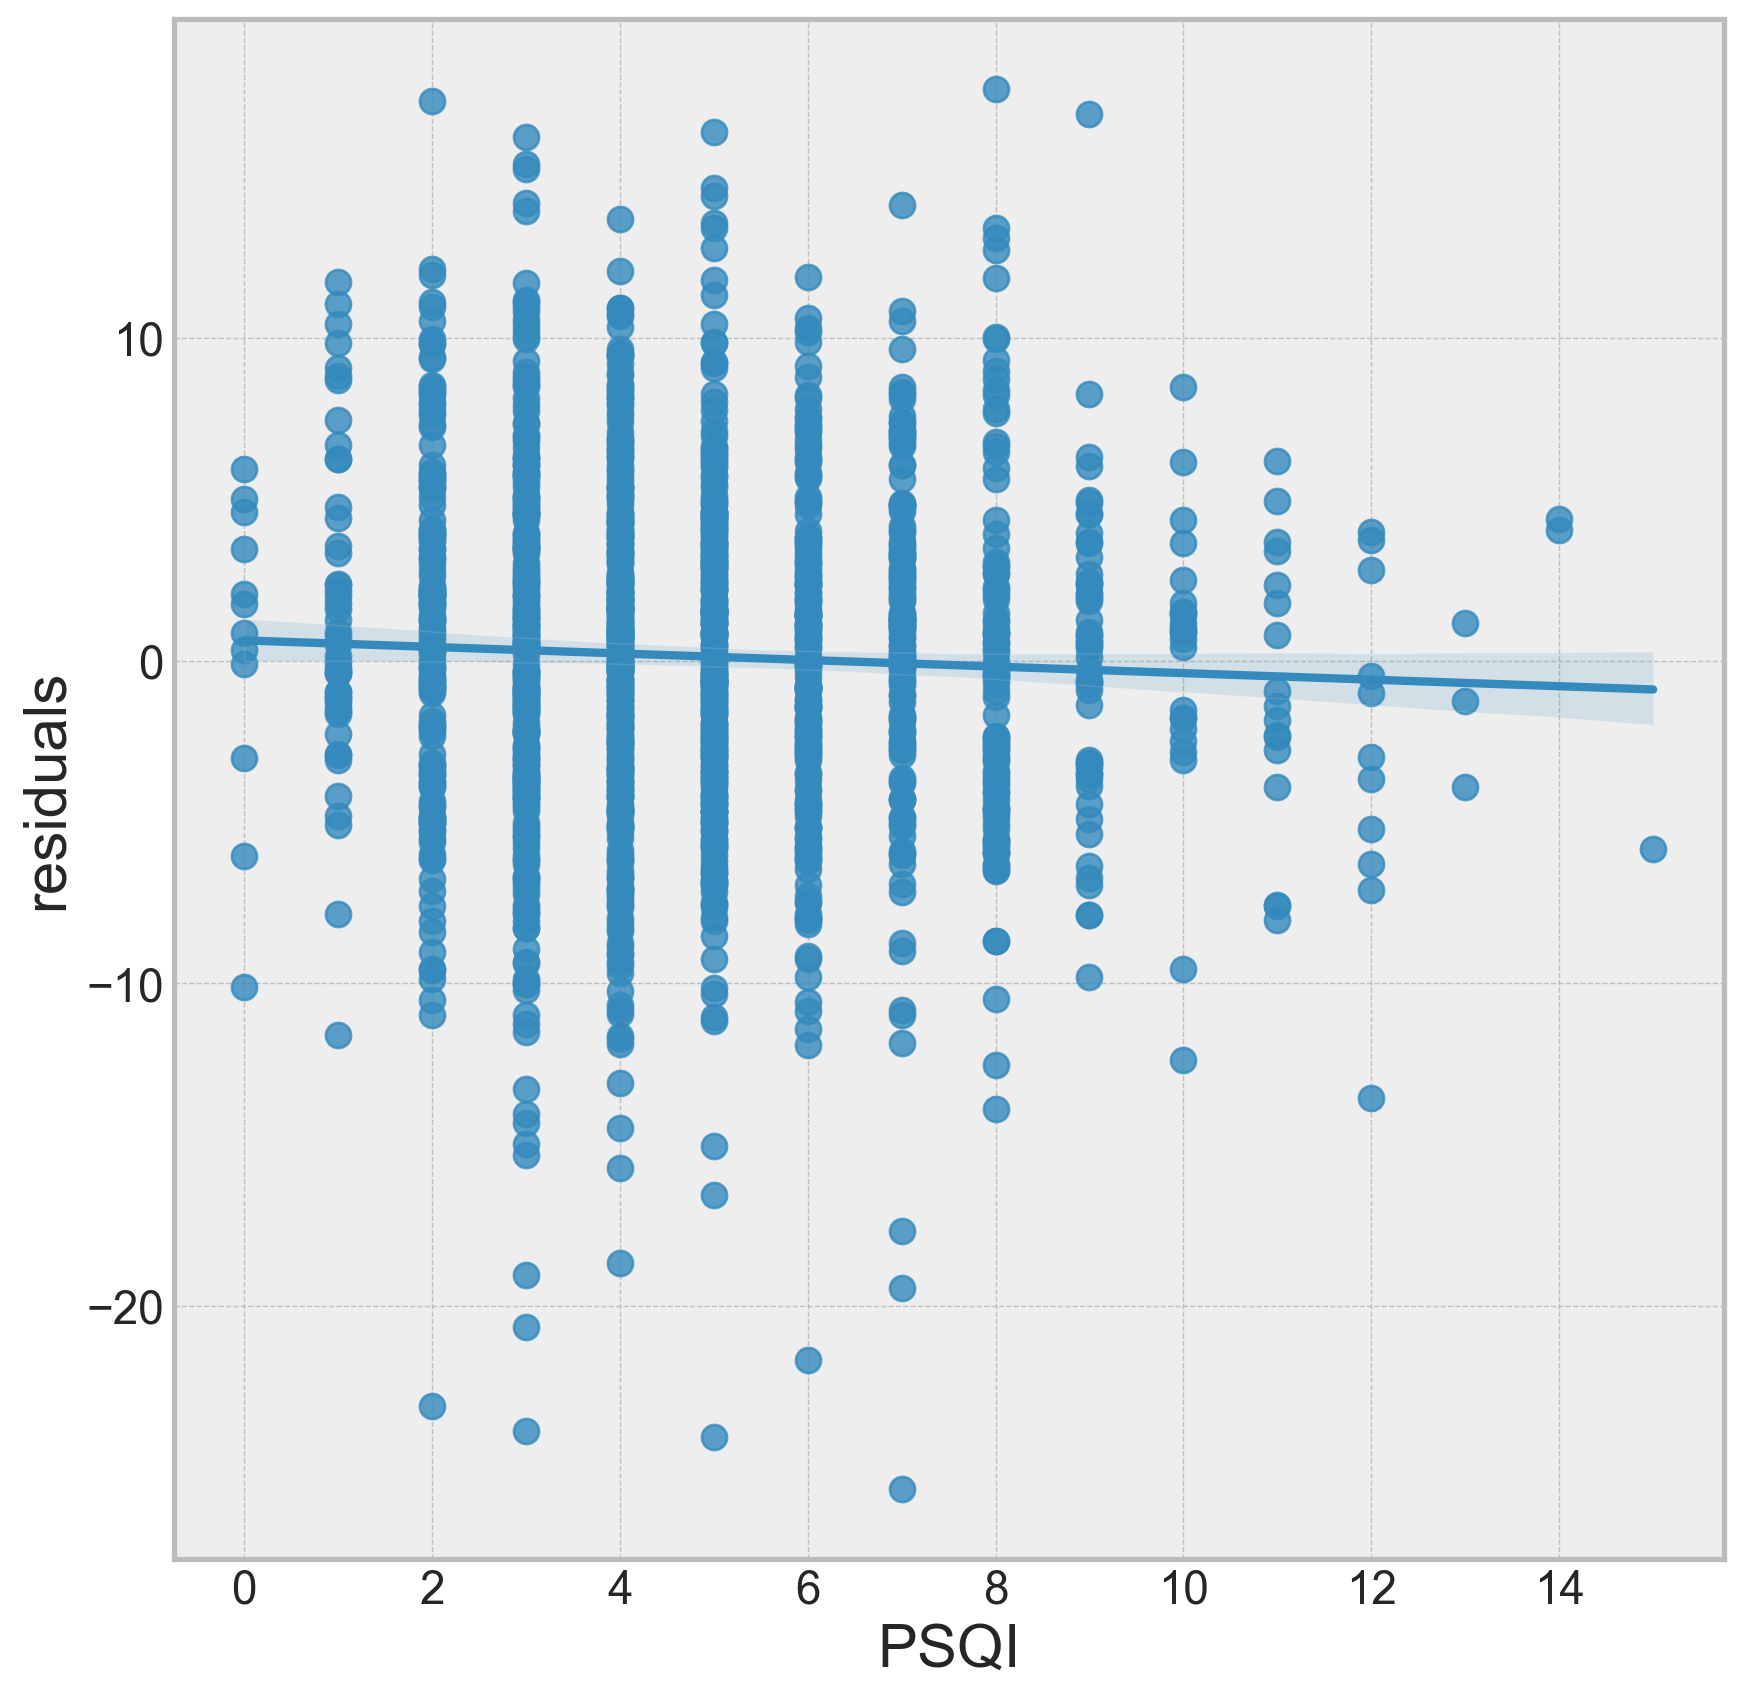

In [183]:
fig,ax = plt.subplots(figsize=(10, 10))
sns.regplot(x=y, y=x, ax=ax)